In [1]:
# Bunch of useful libraries + wngrad
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
import torch
from sklearn.datasets import load_svmlight_file
import random
import helpers
from wngrad import WNGrad
%matplotlib inline

# SVM parameters

In [2]:
DATA_TRAIN_PATH = '../data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
n_instances, n_features = A.shape
A = torch.tensor(A, dtype=torch.float, requires_grad = True)
y = torch.tensor(y, dtype=torch.float, requires_grad = True)
print(y.shape, A.shape)

torch.Size([2477]) torch.Size([2477, 300])


## Optimizer

In [3]:
w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)
optimizer = WNGrad([w], lambda_wn=None)

def train_SVM(A, b, w, optimizer, lambda_svm, nb_of_iter = 100, batch_size = None):
    history = defaultdict(list)
    for i in range(nb_of_iter):
        # 'forward pass'
        if batch_size == None:
            output = helpers.prediction(A, w)
            # Calculate loss
            loss = helpers.calculate_primal_objective(y, A, w, lambda_svm)
            
        else:
            idx = random.randint(0,n_features - batch_size)
            loss = helpers.calculate_primal_objective(y[idx:idx+batch_size], A[idx:idx+batch_size], w, lambda_svm)
            
        loss.backward()
        
        def closure(alternative_w = None):
            optimizer.zero_grad()
            if alternative_w != None:
#                 print('Calculating with alternative w')
#                 output = (A @ alternative_w > 0) * 2 - 1
#                 print('A grad:', A.requires_grad, 'output grad:', output.requires_grad, 'Alt_weights:', alternative_w.requires_grad)
#                 print('Calling calculate_primal_obj...')
                loss = helpers.calculate_primal_objective(y, A, alternative_w, lambda_svm)
#                 print(f'Inside closure: y:{y.requires_grad}, A:{A.requires_grad}, \
#                       alt_w:{alternative_w.requires_grad}, loss:{loss.requires_grad}')
            else:
#                 output = (A @ w > 0) * 2 - 1
                loss = helpers.calculate_primal_objective(y, A, w, lambda_svm)
            return loss
        if 'SGD' in str(optimizer):
            optimizer.step()
        elif 'WNGrad' in str(optimizer):
            if i == 0:
                initial_b = 0
                # Get gradient for orig vector
                with torch.enable_grad():
                    loss = helpers.calculate_primal_objective(y, A, w, lambda_svm)
                    loss.backward()
                gradient = w.grad
                for i in np.arange(-0.5, 0.5, 0.2):                   
                    w_t_close = torch.empty_like(w).normal_(0, 10**i)
                    w_t_close.requires_grad = True
#                     w_t_close = np.random.normal(w.mean(), np.array([10], dtype = float)**i, size = w.shape)
                    with torch.enable_grad():
                        loss = helpers.calculate_primal_objective(y, A, w_t_close, lambda_svm)
                        loss.backward()
                    gradient_close = w_t_close.grad
                    b = (gradient - gradient_close).norm(2)/(w - w_t_close).norm(2)
                    if b > initial_b:
                        initial_b = b
                b = initial_b
                print('initial b:', initial_b)
                optimizer.b = b
            optimizer.step(closure)
        optimizer.zero_grad()
        
        if i % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w, lambda_svm)
            try:
                b_j = optimizer.state_dict()['state'][0]['b_j']
                print(f'iteration={i}, primal:{primal_value:.5f}, b = {b_j}, wt_mean = {w.mean():.2f}, {w.std():.2f}')
            except:
                print(f'iteration={i}, primal:{primal_value:.5f}, wt_mean = {w.mean():.2f}, {w.std():.2f}')
        if i % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w, lambda_svm)            
            history['objective_function'].append(primal_value)
            history['iter'].append(i)
#             history['gradient_norm'].append(np.linalg.norm(gradient))
    
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y.detach().numpy(), A.detach().numpy(), w.detach().numpy())))
    return history, loss

In [4]:
# Train with WNGrad
w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)
optimizer = WNGrad([w], lambda_wn=None)
history_wngrad, loss = train_SVM(A, y, w, optimizer, lambda_svm = 0.01, nb_of_iter = 100000, batch_size = 30)
# Train with SGD (Restart w)
w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)
optimizer = torch.optim.SGD([w], lr=1e-4)
history_sgd, loss = train_SVM(A, y, w, optimizer, lambda_svm = 0.01, nb_of_iter = 100000, batch_size = 300)


initial b: tensor(170.8845, grad_fn=<DivBackward0>)
iteration=10000, primal:229.68579, wt_mean = -0.00, 1.74
iteration=20000, primal:228.72935, wt_mean = 0.01, 1.86
iteration=30000, primal:228.51662, wt_mean = 0.01, 1.91
iteration=40000, primal:228.45177, wt_mean = 0.01, 1.94
iteration=50000, primal:228.35881, wt_mean = 0.01, 1.96
iteration=60000, primal:228.33090, wt_mean = 0.01, 1.97
iteration=70000, primal:228.31769, wt_mean = 0.01, 1.97
iteration=80000, primal:228.31180, wt_mean = 0.01, 1.97
iteration=90000, primal:228.31056, wt_mean = 0.01, 1.97
training accuracy = 0.9951554299555915
iteration=0, primal:2411.34985, wt_mean = -0.00, 0.00
iteration=10000, primal:1075.12280, wt_mean = 0.04, 0.37
iteration=20000, primal:1091.98608, wt_mean = 0.04, 0.43
iteration=30000, primal:1124.58789, wt_mean = 0.05, 0.47
iteration=40000, primal:1147.22021, wt_mean = 0.05, 0.50
iteration=50000, primal:1159.58643, wt_mean = 0.05, 0.52
iteration=60000, primal:1167.48755, wt_mean = 0.05, 0.53
iteratio

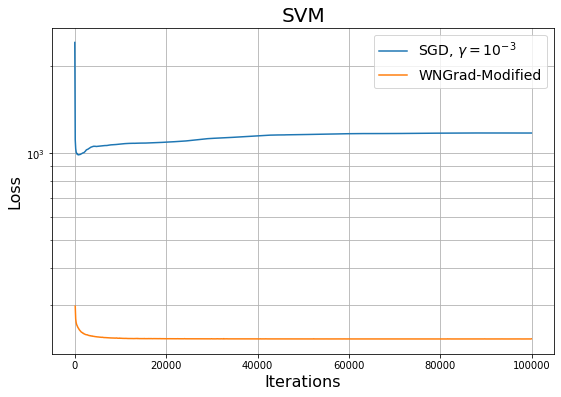

In [6]:
plt.figure(figsize = (9, 6))
fig = plt.gcf()
ax = plt.gca()
plt.semilogy(history_sgd["iter"], history_sgd["objective_function"], label="SGD, $\gamma = 10^{-3}$")
plt.semilogy(history_wngrad["iter"], history_wngrad["objective_function"], label="WNGrad-Modified")
# plt.semilogy(history_wngrad_b2["iter"], history_wngrad_b2["objective_function"], label="WNGrad")
plt.grid(which = 'minor')
plt.grid(which = 'major')
plt.ylabel('Loss', fontsize = 16)
plt.xlabel('Iterations', fontsize = 16)
# plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14})
plt.title('SVM', fontsize = 20)
plt.show()
fig.savefig('SVM')

In [27]:
class SVMWNGrad():

    def __init__(self, n_iter=100, lr=None, lambda_=None):
        self.n_iter = n_iter
        self.lr = lr
        self.lambda_ = lambda_
        
    def fit(self, A, y):

        n_instances, n_features = X.shape
        
        # we need to "wrap" the NumPy arrays X and Y as PyTorch tensors
        Xt = torch.tensor(A, dtype=torch.float)
        yt = torch.tensor(y, dtype=torch.float)

        # initialize the weight vector to all zeros
        self.w = torch.zeros(n_features, requires_grad=True, dtype=torch.float)

        self.history = []
        
        # we select an optimizer, in this case (minibatch) SGD.
        # it needs to be told what parameters to optimize, and what learning rate (lr) to use
        optimizer = WNGrad([self.w], lr=self.lr, lambda_=self.lambda_)
        
        svm_loss = helpers.calculate_primal_objective
        # as an alternative to SGD, we could have used adaptive gradient-based optimization
        # algorithms such as Adam. I don't think they give an improvement in this case though,
        # since the objective function is so simple.
        #   optimizer = torch.optim.Adam([self.w], lr=self.eta)
        for i in range(self.n_iter):  
            def closure(alternative_w = None):
                optimizer.zero_grad()
                output = (Xt @ self.w > 0) * 2 - 1
                if alternative_w != None:
                    loss = svm_loss(yt, At, alternative_w, lambda_)
                else:
                    loss = svm_loss(yt, At, alternative_w, lambda_)
                loss.backward()
                return loss

            loss = optimizer.step(closure)
            self.history.append(loss)
                                      
        print('WNGrad final loss: {:.4f}'.format(loss))